```python
Math 579 Project Documentation

Date: 2025-04-21  
Name: Samisoni Palu  
Instructor: Dr. Sun
```

In [2]:
import chess
from chess import pgn
import json
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

```pyton
## Utils
Board data
---
`generate_uci_move_list`
- list all possible moves as a 2-tuple of from_square, to_square
- tweaked for promotion move counts
- will Include Redundant or Invalid Moves
    - **`a1a1`, `d4d4`**, etc. → no actual move is made
    - **Illegal under any real game condition**
    - Also includes nonsense like `h2h8` (rook-style moves for pawns)

But remember:  
> You’re not saying “these are all valid moves”  
> **this is the full move *vocabulary***—the possible *labels* in a classification task.
> That is, our **vocabulary** list is all the two-tuple pairings of squares, e.g. (`h2g3`), along with other special moves

Our total vocabulary size count includes the sum of
- 64x64 (each pairing of squares)
- 8 (number of columns) x 2 (white-black promotions) x 4 (choices of upgrade) x 3 (capture types) - 16 (edge cases)

We should expect our logits vector to have size **4272**. 

**Benefits of the chosen Vocabulary**

1. Simplicity in Output Shape
    - 1-to-1 mapping: index ↔ UCI
    - You don’t need dynamic output heads or custom decoders
    - You can store logits as `torch.tensor([4672])` and just mask out illegal ones at runtime

2. Consistency
    - Your label space is fixed across:
      - Training
      - Inference
      - Evaluation

3. Non-moves Never Get Trained On
    - No master ever plays `a1a1`
    - So those output indices **never get gradient updates**
    - They just sit in the model—harmless dead neurons

**Why You Might Remove Redundant Moves**

1. Smaller Output Space
    - Saves compute on final linear layer and softmax
    - Slightly faster training (maybe)

2. Model Capacity Allocation
    - You force the network to **only ever consider valid move templates**
    - Could lead to sharper learning curve

But you pay with **more complexity**:
- Dynamic move indexing
- Pre-mask needs to align with training mask
- Harder debugging
```


In [3]:
def generate_uci_move_list():
    all_moves = set()
    for from_sq in chess.SQUARES:
        for to_sq in chess.SQUARES:
            move = chess.Move(from_sq, to_sq)
            all_moves.add(move.uci())
            # Add promotions
            for promo in [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT]:
                from_rank = chess.square_rank(from_sq)
                to_rank = chess.square_rank(to_sq)
                from_file = chess.square_file(from_sq)
                to_file = chess.square_file(to_sq)
                # Only allow forward promotion (white or black)
                if (from_rank , to_rank) in [(6, 7), (1, 0)]:  # white/black promotion ranks
                    if abs(from_file - to_file) <= 1:         # straight or diagonal
                        promo_move = chess.Move(from_sq, to_sq, promotion=promo)
                        all_moves.add(promo_move.uci())
    return sorted(all_moves)

def save_move_index_map(path="data/move_index_map.json"):
    moves = generate_uci_move_list()
    uci_to_index = {uci: i for i, uci in enumerate(moves)}
    with open(path, "w") as f:
        json.dump(uci_to_index, f)

In [4]:
move_list = generate_uci_move_list()
print('Logits size = ',len(move_list))

Logits size =  4272


In [5]:
# board state gets entries from cuhh
PIECE_TO_IDX = {
    None: 0,
    chess.PAWN: 1,
    chess.KNIGHT: 2,
    chess.BISHOP: 3,
    chess.ROOK: 4,
    chess.QUEEN: 5,
    chess.KING: 6,
}

# cuhh make the board go mathematical
def encode_board(board: chess.Board):
    board_array = np.zeros((8, 8), dtype=np.int64)
    
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        row = 7 - (square // 8)
        col = square % 8

        if piece is not None:
            base = PIECE_TO_IDX[piece.piece_type]
            offset = 0 if piece.color == chess.WHITE else 6
            board_array[row][col] = base + offset
        else:
            board_array[row][col] = 0  # empty

    return board_array  # shape: [8,8] of ints in [0,12]


In [6]:
# Here it go right here
board = chess.Board()
encode_board(board)

array([[10,  8,  9, 11, 12,  9,  8, 10],
       [ 7,  7,  7,  7,  7,  7,  7,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 4,  2,  3,  5,  6,  3,  2,  4]])

In [7]:
# this just a mlp frfr
class PolicyNet(nn.Module):
    def __init__(self, embedding_dim=32, num_moves=4272):
        super().__init__()
        self.embed = nn.Embedding(13, embedding_dim)  # 13 tokens -> vector
        self.fc = nn.Sequential(
            nn.Flatten(),                # [8,8,32] -> [2048]
            nn.Linear(8*8*embedding_dim, 512),
            nn.Tanh(),
            nn.Linear(512, num_moves)   # Final logits
        )


    def forward(self, x):  # x: [B, 8, 8]
        x = self.embed(x)  # [B, 8, 8, D]
        return self.fc(x)


In [8]:
mlp = PolicyNet(embedding_dim=2)

### What this do frfr ##


We want a neural network that takes:
- Input: an `8×8` grid of piece tokens (entries are integers from 0 to 12)
- Output: a **4272-dimensional logits vector**

---

### CLASS STRUCTURE: `PolicyNet`

```python
class PolicyNet(nn.Module):
    def __init__(self, embedding_dim=32, num_moves=4272):
```

- **`embedding_dim=32`**: each board square will be represented by a **32-dimensional vector**.
- **`num_moves=4272`**: the size of **output layer**, corresponding to all possible moves.

--- 

```python
        super().__init__()
```

- Standard for initializing the parent class (`nn.Module`).

---

### Embedding Layer

```python
        self.embed = nn.Embedding(13, embedding_dim)
```

- This layer turns each square’s integer (0–12) into a vector of dimension `[embedding_dim]`.
- `[8,8]` board → `[8,8,32]` tensor.

---

### Fully Connected Network (MLP)
These are our hidden and output logits layer. 
```python
        self.fc = nn.Sequential(
            nn.Flatten(),                
            nn.Linear(8*8*embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_moves)
        )
```

#### `nn.Flatten()`
- Converts `[B, 8, 8, 32]` into `[B, 2048]`, similar to .view
- Needed to feed into `Linear` layers

#### `nn.Linear(2048, 512)`
- Fully connected layer reducing 2048 features to 512 neurons

#### `nn.ReLU()`
- Non-linear activation to let the model learn more complex patterns

#### `nn.Linear(512, num_moves)`
- Final layer: predicts logit value for each of the 4672 moves

---

### `forward` Function

```python
    def forward(self, x):  # x: [B, 8, 8]
        x = self.embed(x)  # [B, 8, 8, D]
        x = x.permute(0, 3, 1, 2)  # Optional: [B, D, 8, 8]
        return self.fc(x)
```

- **Input**: `x` is a batch of boards, shape `[batch_size, 8, 8]`
- **Embedding**: turns each square into a vector: `[B, 8, 8, 32]`
- **FC Network**: outputs a `[B, 4272]` tensor of logits

---

## Summary

- network **understands piece identity** through embeddings.
- it **flattens** the board to make a prediction using fully connected layers.
- The output is a **score for every possible move**, and later **mask illegal ones**.

In [9]:
mlp = PolicyNet(embedding_dim=2)
g = torch.Generator().manual_seed(2147483647)

## DATA SETS

Documentation *X*:**INPUT** and *Y*:**TARGET** 

*X* is a **board state**.

> **Board state:**  
> - *8×8 matrix*  
> - Entries in `[0, 12]`  
> - Entries map to **piece type**  

*Y* is a list of **move indices**.

>**Move Indices (`logits`):**
> - vector in $\mathbb{R}^{4272}$
> - entries map to a **move**

A reminder of how moves are defined follows. 

>**Move:**
> - pair of grid values (Why?)
> - e.g. *d3d2*

Recall that the policy net (MLP) outputs a **softmaxed** list of (logits). Training occurs via `cross_entropy`. We read move data from text file in **PGN form**. X lists all the board states of a given game in the order it was played. Y lists all the moves made from a given board state. Let $S_i$ be the $i$ -th board state of the given game, and let $a_i$ be the action (move) made from this state. Then, we may visualize $X$ and $Y$ as the following:

$$\text{Input:}\ S_1,\ S_2,\ ...,\ S_n$$

$$\text{Output:}\ a_1,\ a_2,\ ...,\ a_n$$



In [10]:
in_data = 'C:/Users/samip/Documents/quick-maffs/neural_nets/makemorechessmoves/data/raw_games/Carlsen.pgn'

def load_dataset(raw):
    with open(raw, "r") as file:
        game = pgn.read_game(file)
        board = game.board()
        X, Y = [], []

        for move in game.mainline_moves():
           board_state = encode_board(board)  # BEFORE the move
           try:
               move_index = move_list.index(move.uci()) # move is INDEXED here, move list starts from first move
               X.append(board_state) # first board state is neutral board, it must be appended to have good beginning game
               Y.append(move_index)
               board.push(move)  # Move AFTER data capture
           except ValueError:
               print(f"Move {move.uci()} not found in move_list. Skipping this move.")
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
#what happens if we remove winning move (movelist[-1]), will the model still choose victory? >:P

In [11]:
X,Y = load_dataset(in_data)
n1 = int(0.8*len(X))
n2 = int(0.9*len(X))

# shuffled indices
newInd = torch.randint(low=0,high=Y.shape[0],size = (X.shape[0],))

# shuffle X and Y to match
X = X[newInd]
Y = Y[newInd]

Xtr, Ytr = X[:n2],Y[:n2]
Xdev, Ydev = X[n2:],Y[n2:]

C:\Users\samip\AppData\Local\Temp\ipykernel_6984\2948434525.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X = torch.tensor(X)


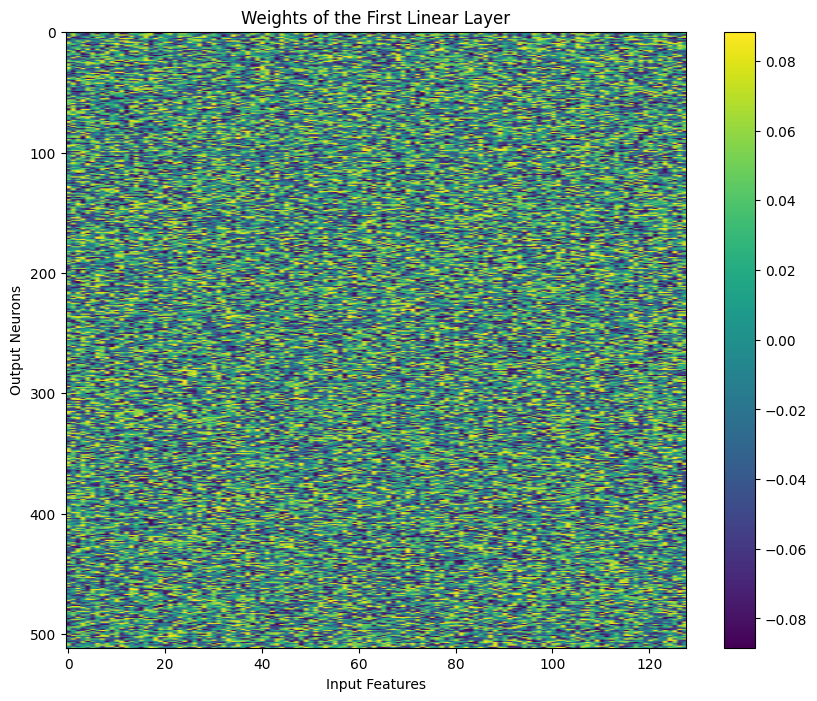

In [12]:
# Extract weights from the first linear layer
weights = mlp.fc[1].weight.detach().numpy()

# Plot the weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Weights of the First Linear Layer")
plt.xlabel("Input Features")
plt.ylabel("Output Neurons")
plt.show()

**A Note on Initialization**

> We must initialize our layers carefully in order to optimize training speed in the gradient step. 

Consider $tanh$ activation for instance: 


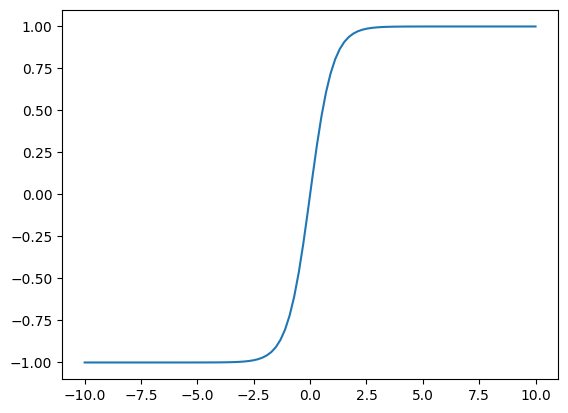

In [13]:
plt.plot(np.linspace(-10,10,100), np.tanh(np.linspace(-10,10,100)))
plt.show()

Note that gradient values for large $x$ of `tanh` are close to 0. In essence, neurons may be killed off too early with a sloppy initialization. 

Due to this fact, you might consider `ReLu` for its beneficial properties, including: 

- no upper bound
- no vanishing for positive inputs
- easier initialization

allowing for faster training and increased stability. Our policy net (MLP) already initializes efficiently using layers defined by the `nn` package, but the point is clear, 

> We should fix our initializations depending on what activation function is used. 

This is useful later when we compare different bot models in competition. 

**Training Step**

We start with a very minimal training loop.
- static learning rate
- no optimizers
- no batch normalizations (in fact, we won't need it)

In [14]:
mlp = PolicyNet(embedding_dim=2)

In [15]:
count_step = 10
count_step_tops = 10
lossi = []
num_steps = 1000
#lr = torch.logspace(-3, 0, steps=num_steps)
lr = 0.23
batch_size = 16
top1_list, top5_list = [], []

for i in range(num_steps):
    batch = torch.randint(low=0,high=Ytr.shape[0], size=(batch_size,))

    logits = mlp(Xtr[batch])
    loss = F.cross_entropy(logits, Ytr[batch])

    
    for p in mlp.parameters():
        p.grad = None
    loss.backward()
    for p in mlp.parameters():
        p.data += -lr*p.grad
    if i%count_step==0:
        print(f'Step[{i}]: Current loss value = {loss}')
    if i%count_step_tops == 0: 
        top5 = torch.topk(logits, k=5, dim=1).indices  # [batch, k]
        correct = top5.eq(Ytr[batch].view(-1, 1)).any(dim=1).float()  # 1 if Y in top-k
        top5_acc = correct.mean()

        top1 = torch.topk(logits, k=1, dim=1).indices  # [batch, k]
        correct = top1.eq(Ytr[batch].view(-1, 1)).any(dim=1).float()  # 1 if Y in top-k
        top1_acc = correct.mean()

        top1_list.append(top1_acc)
        top5_list.append(top5_acc)
        print(f'Top-1: {top1_acc}, Top-5: {top5_acc}')
    lossi.append(loss.item())


Step[0]: Current loss value = 8.389375686645508
Top-1: 0.0, Top-5: 0.0
Step[10]: Current loss value = 3.1352336406707764
Top-1: 0.1875, Top-5: 0.75
Step[20]: Current loss value = 2.009864091873169
Top-1: 0.3125, Top-5: 0.875
Step[30]: Current loss value = 1.2035493850708008
Top-1: 0.5625, Top-5: 1.0
Step[40]: Current loss value = 0.5585005879402161
Top-1: 0.875, Top-5: 1.0
Step[50]: Current loss value = 0.598530650138855
Top-1: 0.6875, Top-5: 1.0
Step[60]: Current loss value = 0.6099321842193604
Top-1: 0.6875, Top-5: 1.0
Step[70]: Current loss value = 0.7693657875061035
Top-1: 0.6875, Top-5: 1.0
Step[80]: Current loss value = 0.17468445003032684
Top-1: 0.9375, Top-5: 1.0
Step[90]: Current loss value = 0.3840239346027374
Top-1: 0.875, Top-5: 1.0
Step[100]: Current loss value = 0.12583497166633606
Top-1: 1.0, Top-5: 1.0
Step[110]: Current loss value = 0.12002240121364594
Top-1: 1.0, Top-5: 1.0
Step[120]: Current loss value = 0.05791793018579483
Top-1: 1.0, Top-5: 1.0
Step[130]: Current l

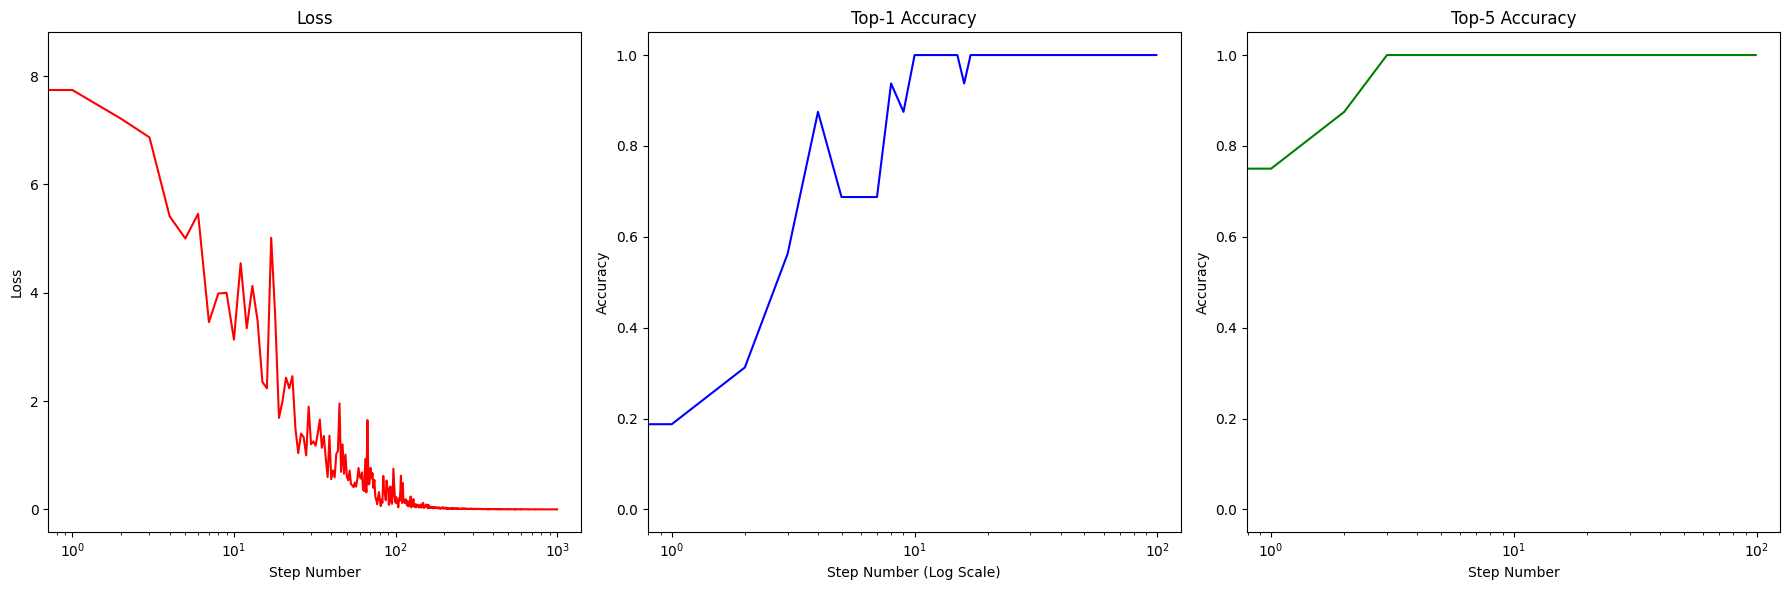

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Loss
axs[0].plot(lossi, color='red')
axs[0].set_title("Loss")
axs[0].set_xlabel("Step Number")
axs[0].set_xscale("log")

axs[0].set_ylabel("Loss")

# Plot Top-1 Accuracy
axs[1].plot(top1_list, color='blue')
axs[1].set_title("Top-1 Accuracy")
axs[1].set_xlabel("Step Number (Log Scale)")
axs[1].set_xscale("log")
axs[1].set_ylabel("Accuracy")

# Plot Top-5 Accuracy
axs[2].plot(top5_list, color='green')
axs[2].set_title("Top-5 Accuracy")
axs[2].set_xlabel("Step Number")
axs[2].set_xscale("log")

axs[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [17]:
with torch.no_grad():
    val_logits = mlp(Xdev)
    val_loss = F.cross_entropy(val_logits, Ydev)
    print(f"Validation loss: {val_loss}")

Validation loss: 2.9306933879852295


In [18]:
mlp = PolicyNet(embedding_dim=2)
criterion = nn.CrossEntropyLoss()


In [19]:
import copy

count_step = 10
count_step_tops = 10
lossi = []
num_steps = 1000
#lr = torch.logspace(-3, 0, steps=num_steps)
lr = 0.002
batch_size = 16
top1_list, top5_list = [], []
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

grad_log = []


for i in range(num_steps):
    batch = torch.randint(low=0,high=Ytr.shape[0], size=(batch_size,))
    optimizer.zero_grad()
    logits = mlp(Xtr[batch])
    loss = F.cross_entropy(logits, Ytr[batch])
    loss.backward()
    optimizer.step()
    scheduler.step()

    
    
    if i%count_step==0:
        print(f'Step[{i}]: Current loss value = {loss}')
    if i%count_step_tops == 0: 
        top5 = torch.topk(logits, k=5, dim=1).indices  # [batch, k]
        correct = top5.eq(Ytr[batch].view(-1, 1)).any(dim=1).float()  # 1 if Y in top-k
        top5_acc = correct.mean()

        top1 = torch.topk(logits, k=1, dim=1).indices  # [batch, k]
        correct = top1.eq(Ytr[batch].view(-1, 1)).any(dim=1).float()  # 1 if Y in top-k
        top1_acc = correct.mean()

        top1_list.append(top1_acc)
        top5_list.append(top5_acc)
        print(f'Top-1: {top1_acc}, Top-5: {top5_acc}')
    lossi.append(loss.item())


Step[0]: Current loss value = 8.368372917175293
Top-1: 0.0, Top-5: 0.0
Step[10]: Current loss value = 3.243715286254883
Top-1: 0.25, Top-5: 0.6875
Step[20]: Current loss value = 2.105419635772705
Top-1: 0.5, Top-5: 0.8125
Step[30]: Current loss value = 1.7811014652252197
Top-1: 0.4375, Top-5: 0.875
Step[40]: Current loss value = 1.6846230030059814
Top-1: 0.375, Top-5: 1.0
Step[50]: Current loss value = 0.6827413439750671
Top-1: 0.875, Top-5: 1.0
Step[60]: Current loss value = 0.8693398237228394
Top-1: 0.75, Top-5: 1.0
Step[70]: Current loss value = 0.9824639558792114
Top-1: 0.6875, Top-5: 1.0
Step[80]: Current loss value = 0.6655216217041016
Top-1: 0.75, Top-5: 1.0
Step[90]: Current loss value = 0.37631842494010925
Top-1: 0.9375, Top-5: 1.0
Step[100]: Current loss value = 0.476836234331131
Top-1: 0.875, Top-5: 1.0
Step[110]: Current loss value = 0.2842259705066681
Top-1: 0.9375, Top-5: 1.0
Step[120]: Current loss value = 0.35987144708633423
Top-1: 0.875, Top-5: 1.0
Step[130]: Current l

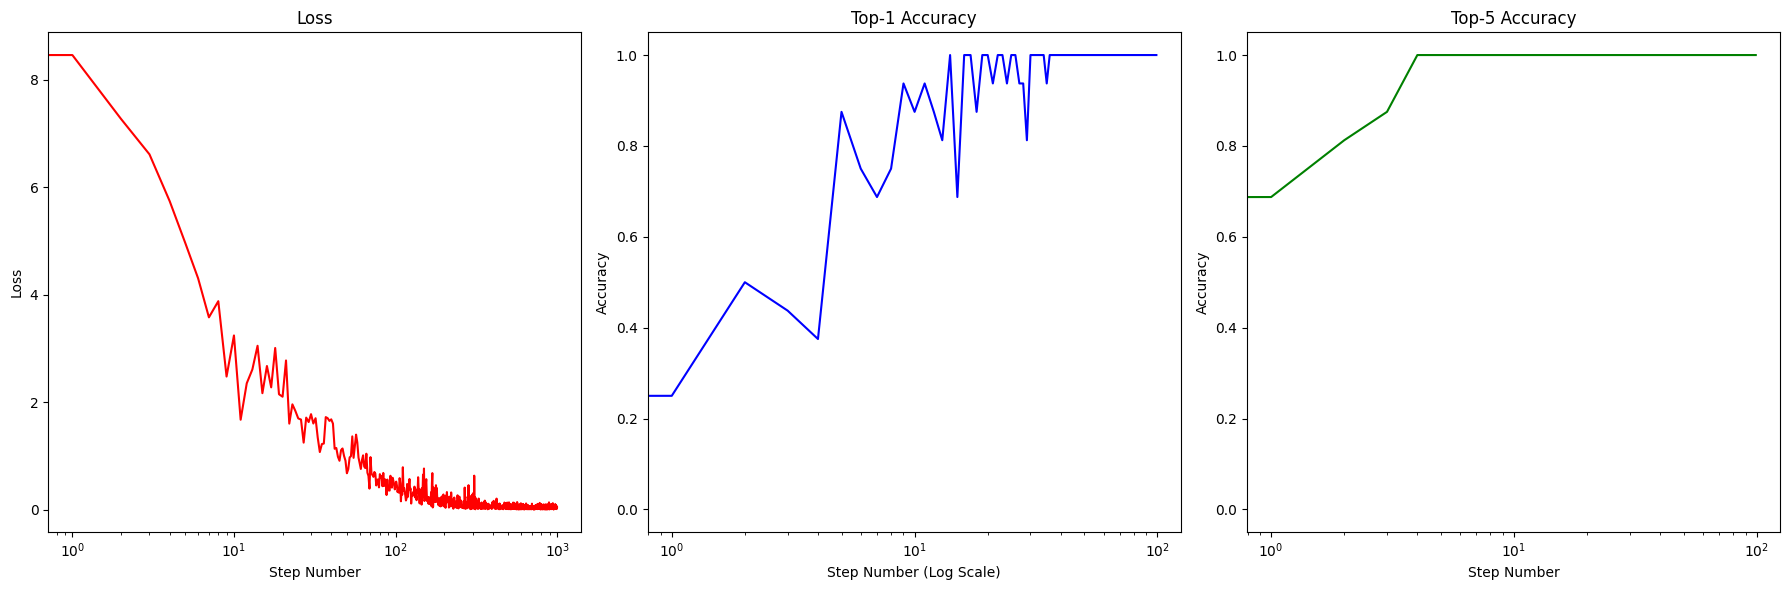

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Loss
axs[0].plot(lossi, color='red')
axs[0].set_title("Loss")
axs[0].set_xlabel("Step Number")
axs[0].set_xscale("log")

axs[0].set_ylabel("Loss")

# Plot Top-1 Accuracy
axs[1].plot(top1_list, color='blue')
axs[1].set_title("Top-1 Accuracy")
axs[1].set_xlabel("Step Number (Log Scale)")
axs[1].set_xscale("log")
axs[1].set_ylabel("Accuracy")

# Plot Top-5 Accuracy
axs[2].plot(top5_list, color='green')
axs[2].set_title("Top-5 Accuracy")
axs[2].set_xlabel("Step Number")
axs[2].set_xscale("log")

axs[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

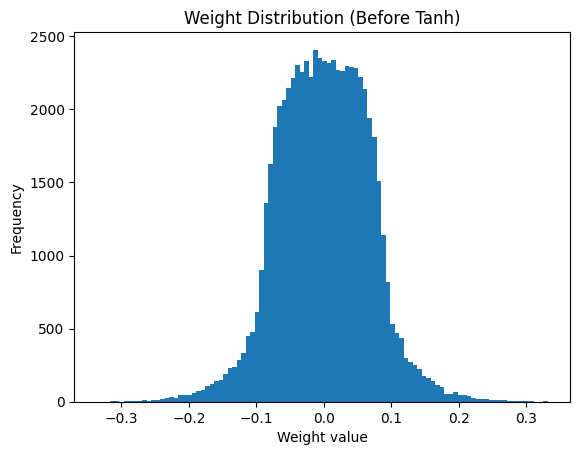

In [21]:

# Get weights of a layer
weights = mlp.fc[1].weight.detach().cpu().numpy()  # Assuming layer 1 is Linear

# Flatten and plot
plt.hist(weights.flatten(), bins=100)
plt.title("Weight Distribution (Before Tanh)")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()


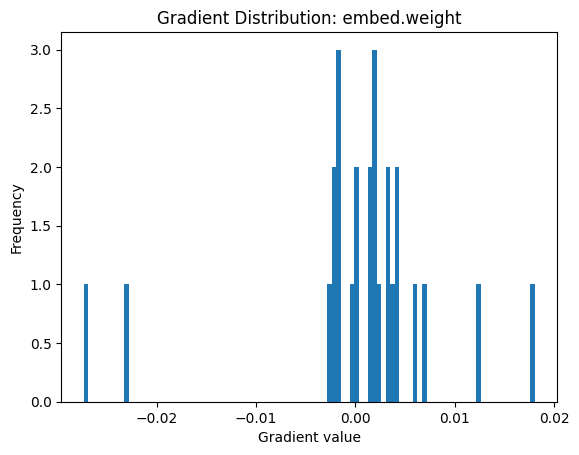

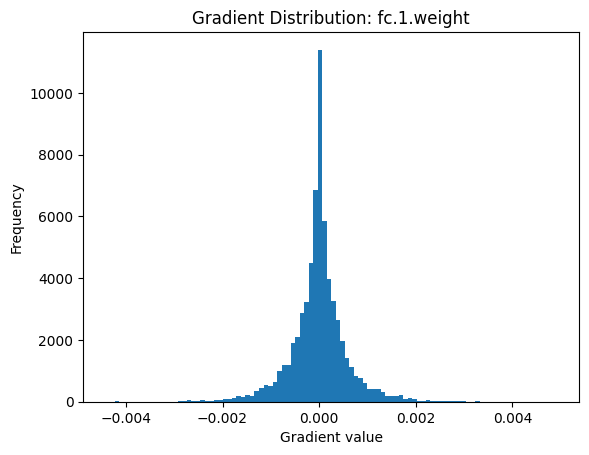

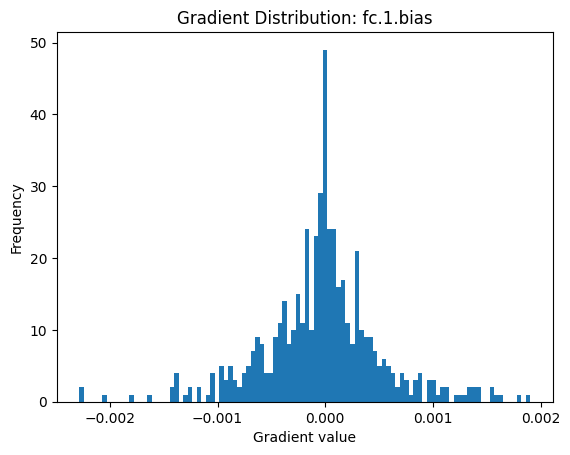

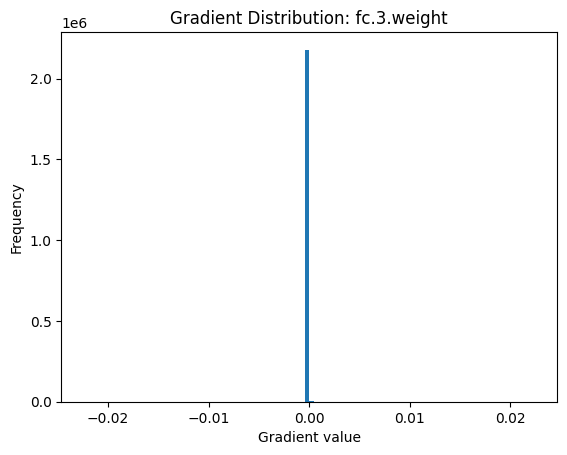

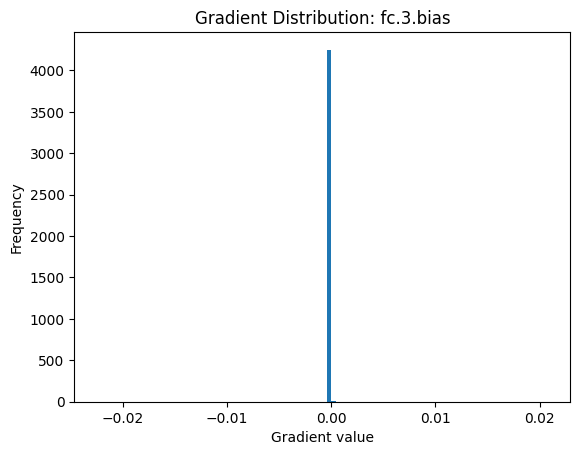

In [22]:

for name, param in mlp.named_parameters():
    if param.grad is not None:
        grads = param.grad.detach().cpu().flatten().numpy()
        plt.hist(grads, bins=100)
        plt.title(f"Gradient Distribution: {name}")
        plt.xlabel("Gradient value")
        plt.ylabel("Frequency")
        plt.show()


## Tests

### Independents
**Optimizers**
**LRs**
**Activation Functions**
**vs Stockfish**
**Model Dimensions**
- layer no
- layer size
**embed vs one hot**
**embedding dimensions**
**batch size in training**
**argmax vs softmax**
**different training data**


### Metrics
**Win Rate**
**Training Speed**
**Stability**
**embedding visualization**

### To do 
- embedding visualization

### Functionality

With our first test, we should gauge how well the base model plays. We first define a move selecting function...

In [23]:
def select_move_softmax(model, board, move_index_to_uci, uci_to_index, temperature=1.0):
    model.eval()
    with torch.no_grad():
        # Encode the board
        board_tensor = encode_board(board)
        board_tensor = torch.tensor(board_tensor, dtype=torch.long).unsqueeze(0)  # Add batch dim

        # Forward pass
        logits = model(board_tensor)[0]  # remove batch dim, shape [4272]
        
        # Mask illegal moves
        legal_moves = list(board.legal_moves)
        legal_move_indices = []
        for move in legal_moves:
            uci = move.uci()
            if uci in uci_to_index:
                legal_move_indices.append(uci_to_index[uci])

        mask = torch.zeros_like(logits)
        mask[legal_move_indices] = 1

        # mask
        logits = logits + (mask - 1) * 1e9  # large negative for illegal moves

        # Apply temperature scaling
        logits = logits / temperature

        # Softmax
        probs = F.softmax(logits, dim=0)

        # Sample
        move_index = torch.multinomial(probs, num_samples=1).item()
        
        move_uci = move_index_to_uci[move_index]
        return chess.Move.from_uci(move_uci)



In [24]:
index_to_uci = {index:move for index,move in enumerate(move_list)}
uci_to_index = {move:index for index,move in enumerate(move_list)}

... as well as a game loop. 

In [25]:
def model_vs_itself(): 
    game = []
    board = chess.Board()
    while not board.is_game_over():
        move = select_move_softmax(mlp, board, index_to_uci, uci_to_index, temperature=1.0)
        board.push(move)
        game.append(move.uci())
    return game

In [26]:
# Three games
game1 = model_vs_itself()
game2 = model_vs_itself()
game3 = model_vs_itself()

print(len(game1))
print(len(game2))
print(len(game3))

243
301
602


Typically, well-played games range between 40-80 moves. 

In [27]:
pgn_game = chess.pgn.Game()
pgn = pgn_game


for move in game:
    pgn = pgn.add_variation(chess.Move.from_uci(move))

print(pgn_game)

NameError: name 'game' is not defined

In [ ]:
with open("output_game.pgn", "w") as file:
    file.write(str(pgn_game))